In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Turnover Rate Test

In [3]:
def test_turnover_time(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, size=100,
):
    total_pvalues = []
    total_turnovers = []
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalTurnover(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        turnovers_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        turnovers = []
        with turnovers_io:
            reader = csv.reader(turnovers_io)
            next(reader)

            for row in reader:
                turnovers.append(float(row[0]))
        turnovers = np.array(turnovers)
    
        # Calculate in the dispersal locations
        gof = kstest(turnovers, expon(loc=0.0, scale=2.0).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_turnovers.append(turnovers)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Turnover histograms:"))
    
    turnovers = np.concatenate(total_turnovers)
    
    # Draw the turnover time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(turnovers), np.max(turnovers), 1000)
    loc, scale = expon.fit(turnovers)
    
    ax1.set_title(f"Individual turnover times PDF")
    ax1.set_xlabel("turnover time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax1.hist(turnovers, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual turnover times CDF")
    ax2.set_xlabel("turnover time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax2.hist(turnovers, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:


* p-value: 0.8781918461440662
* statistic: 1926.5072297140962

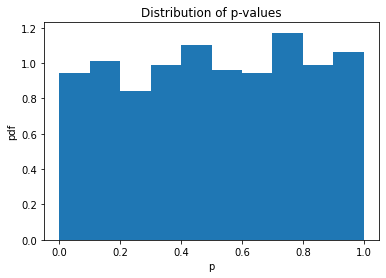

#### Turnover histograms:

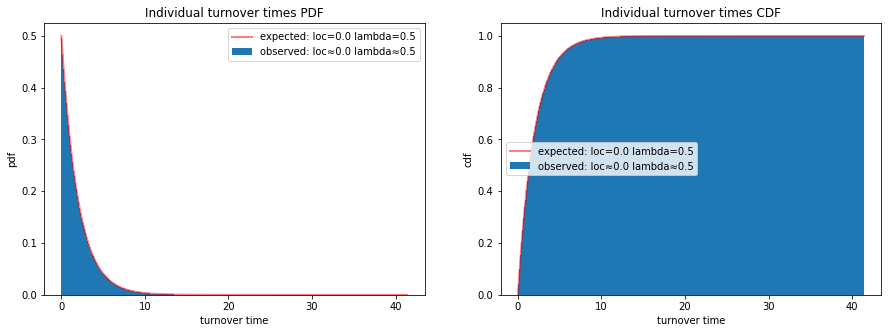

#### Parameters:
* seeds: [14225096364927119535 13081192450275980043 10035451242644482206
 15868966623004452080 11248705818398776452  1216846179410233402
  6183686111165202993 16511925683090735526 10781962845589803255
 10816745988769000647  7650565836485285948  3823519439870529743
 17654548785952425157  5125985600897173588 11452422976166897406
   141209014529538264  3446287849421049298  3398037333600712803
  2020529482069180891  1772777056011577804 15754311748213349974
 10982643091816392389 15416394658000171294  4962131212626660893
  1362851443129250670 17518402526943881023  8135150461807355695
 10654230917880322429 17713306023539929745  2147178487760373474
 11994100594873837005  3520335061273409210 11520272664808183989
  1629243911672298827  2283828643100523859  6842896869901437387
 15179751722656700206 16133536298546338550  2124561676997857911
 15821826588894176674 11188183711797289164  1721002583008251488
 15524909408345787378 14806787531598534990  1168860422005827911
  8145965440013715642 12609141336323726686 18440511426910220951
  1634990979487013417 13597161848669833902  9751887824462737470
  7456971898730108886  1344101983091563256  1216529676470882714
  7065004164008033282 17092115600261408201  1710564078890397048
  6807002066545702373  9332595148746038931 11867981372063743273
 10045222644312035226  3808508801779891101  7549733031119911948
  4543302627665017679  6490021277548726157 16935495041593737741
 16381804165981783204  6951269645334339531  5046955362222334958
  6122098138594343994   525606605296424105  9956703448722599281
 10916807363190333815  3780811214627157085 12084880025623398921
 13305151063006977598 11633230495722277259 16209770499194842585
 11094714406970803617  6208989523813280795  7590874341667928792
 13207345291106451220 13965985119631080825  7733778681839371695
  1724096443742741857 16008030197570768941 16531185659429424295
  6149320736078981253   839472105506537808 17222684602600399463
 15785954394382408514  7756740898466406760  6425623334880359571
  4189386818252790471 16728474155277226757  7915294578501425077
  2146545674147384682  6107122656637935641  5119207088735661958
 10089653425707493419  6701053102128408445  9565183074978095357
  4792307669704947306  6910951325190653806  4085009296444387602
  1908742503144887157  5809181839553365744 13497509286938117370
 16504461847330813182 15182820081995675149     1737907845057513
 15392126466971002921 13061267919769747856  8430039070217766575
 17291954313024680872  9043219131964943223 16814460080796955675
 14924041456093698750 17854548886985179806 15053960641706612513
  5794861031356327208 11703338053046785996  5253253496482134795
 16033174099035229906 12652246730572466093 13269945291006641423
  7886661277219555688 14497229373987428327  2913303008634908409
  6772843829596988312 10479511537703359077 10822177388765575505
  2087637421245189039  2702144337248838306 16267932474737325216
    29064587172576864  9803652015402991292   817168647949381407
 12433100596139713704  7023355596576515860  9017285526880987741
 12972521632092305267  3640758296528069067  8424882705365691675
  8945441473011047553  5863652410332721711 13308838372723635346
 11033870955821362572     9784027210778237 16471445564246648072
 16442145757181020225 15998906279677984176 11893874619534006550
  2173418512872301064 10281362897113056854  1897431497478521950
  9129986005038078236 11280999506937784194  8508122788011467570
  5593498568531310040 12003389870518363144  1326581074020086140
  8735583825073608092 15501264591660771091 16387076028266881313
 14965192156351810281 15750741419055558984 14160668204112236838
 17324314446454380168 12280225381419300805 18279004498915933499
  8534408632751980640 16094597398055550003  3781124700559923945
  4808291598488669333  2788821059347049389 10400430642744246842
 11727265507110703506 14484852455161946498 14109720693603590247
 12153343824911423908  1613155060354643953  8342470763318787633
  4945735715086325437 12663156957168898091  7181935194104419786
 14945653413794113684  3154087312674806602  3687496282522257032
  9736582234055654658  4732301171792031996    15225000969368029
  1060497685947945762  6327922843631635583  3759477336271569465
 13342496958859390832  1345036867176897539 18198207791197226206
  9385637416883861337 13619688197508002142 17811791160312449183
    64810403717906710  7232863076758421682  5797399790500554253
 10315590300282833701  6197315587996389206 13247456635506673886
 14168989213823446561  5796996341927445483 18012624449325857492
  2356506023879190652  1491627132410502643 14028120957816081168
 12780819541054874492  4214757513515021717  5891866459246350163
  7956171395317521879 16629468939120374695  9584969364784895764
  7354819341151858084 17000693337776424928 14821969896529430921
  7695867853773950758 12722732372201574228 13404169876608954118
 18443490633953895499  3172213203458319238 16627781633383860514
  9953173628426289608 17739628447712789892 16682540212605762987
  7667117917232494051 12973035091949519420  2938298597818394852
  8369358423496468563 11104056627398890067  2037823952350361291
  8488012445021783561 12804304332151593861 17150553270812477204
  1937725224759678748  2820016189482395884 15360597832713393663
 10959990831963742903   474390977999682849 11309473388954137296
  8556161292347277808  4984011254237071984 11724136116964583774
 18201240484755663360 18291496490722896175 11450925879853756795
 16245379046343181757  8090962620657076623  6955336514896390871
  5250554750993104170  1750271773432182504  9095462907981782414
  8420332161948128699 10123818599507511310  8201839967115084488
 13857852637712152954 10804260967961117655 15379836857365835622
  7060308205375164903  6882572130421886194  5068303054245900255
  1092952427935287766   916118503558400434  7524704307585076036
  4370453326998515390 11494270825432523941  7110359273112366574
  4145564892567784726  1131335712003782000  2295506728789586413
  8483040613974837426 12491950979159893291  5478382818008082123
 17512128013952283804  4521358663530877202   684840082112799040
  5981908975017908732 10374209747512561829  5004730236237367898
 10913467427895872984 17366662707644909635 13347486838546790588
  8694525284445820057 12825497411003660689 11315621492648983088
  4660669002721034520 17651302233070237686 17616171098628570231
  2497874010936192762 12303980958241551691  2285665431801306468
 17271622692936168324  6117885243420066478  9679135118440246372
  9756590428115283577  8866893415247663325 12583026130028041292
  9520512691484346833 11632393513296155293  9780177206882965858
  9936706505087700820 15730099794807323842  4308830678121567543
 11633918966273368335 13606266299810175618 14852113114839234340
 10115509470213564974  6171069857736683050  4717620853024981615
  3065094845886085039 12448851373620834284 12908157921251496028
 18272984111606318403   991786549016236112 15042613705271462625
  2490079363593438536 14158825032946487202  1314609572550689461
  9115528814741047353  7201408535051437974  1796078765481169068
  7284039836945002224 15309877741023555054 14780924930803717332
  3350888184398273770  6849435008047485685  4055796324250426801
  9406205524587801790  3226312213834049898  5720295226429800351
  4906964944920495581  9121643207838847739  5056211999236226094
  3982865209374930844 10413211019533658336 14902868883389570810
 12921009591259847002   581757857351455532 12143382496498107154
  1421141029261405546  3754349511412997516 10086563035603662396
  1792484725903289668 16367334684666503613 10728845326324339337
 13573298643393877227   764250031190944720 13549532016273168326
  6600382419075390822   771161039119301615 14951758480610981661
  4144095273204528606  5484198063222790344   811963414645360471
  4912788467575372488  9512400757112380722 17139071418681154975
  9715076899327423319 14801613983071117115  6106705757636571179
 18360007428923134659 16168092617460722895  6495058723437316368
  9632248120066662801  8471290966216009669  6799673661442221808
  6728803348050663589  4095300611831370474 16165690460782614362
  2072205229460201973   320261147166050579  3152272644294721889
   710982884805913590  4708568598240231532 17257786042899169056
 12727111718384074529  5778551613250330027 12919828267356014716
 14185856948055717113  3183850177208999680 11077969817597013716
  2790565964698011603  1242619038079394779  2541100815681893400
  3521503931595036182 13708076367554715704  9245349300802886837
 10878117360737792813 16992336635328385311 16418565834273595444
 16111135305433476875  5317508456218755251  2035807861611850878
  4154435345941311409  6759185773051168383   276569316005313231
  5858796211145279677 17573287682938297927 12386969969217727618
  4303478029303201087 13514546156657035228  8930267259744994075
 14025613021002521651  8668962035569925276  9140892561908874679
 14319586131600007317  7221835467753391618 13352152366756893672
 14707572607436768519  6194743448192440715  8695562513298247263
 10447631542160627432 16819629712880563382 12397637075098801321
 13149401592370739029  2398628476648145974  5796499167341912298
 13804820460236408110 12150976241056457759   160069480428504340
 11925078971488350635  1387633915864345378 13670192962035543966
   915106293209768966 18384516673261685145 15502463919241538690
  9921412984704770505 14182933089162655077 15421551017394224290
 13364140847460213530  9902869740568097893 10686219822989240124
 11473621871619510615  5951696513858839397 11699857183121001469
 11910957908104890514 16545694387304008835  7327234803929392105
 15296655102109813181 17516156612869202967 14351540622344785903
 15750473605156481540  9028020259282013357  2662134923910031474
  3981646319552474233  2247210523808018714  4362245629709660465
  5066798959802087380 16734364592823817020 16285083186937331481
   817235561364769101  3390870022571650355 15935071830893422470
  4584159307571020185  1853623274336340286 11994191402070927302
  8885059425841126093 14444476091374336932  2138670788876014451
  6517222139757892751  8510806525227260513  2257789685101527837
  4488958045424879859  4265253216310822549  5144031162796723456
 13140185210083241537 15423032704512700590 15506980488079320530
  6934276485453756170 16624074627710353869  6771423584193812591
  4397688560297007882  4078344336427557499  5198420098626877476
 17029839239674408648 17726558587972871941  9178927967042500775
  6411233399453499306 13369645707462359044  6290789951599797248
 11852081401189123419 15907724594030845299  3148739788219392786
  4320688049343853878  5617232356445518905 18048777886537421663
  6474502793883919416 10662039620005541256 14396095381004735283
 16844004856518455187 13745622877794330343 18107488930446515329
 14273683212938504477 15270960222520181920 14515391395423558524
 10507626396223412460  9992973980914369765 17075819704264497370
  9102943000063758994 14541506793728920823 11951802257658750643
 14251914408226917008  8512441586957864948  2779798871581131190
  9013434257011207648 11746306844166481987   800366747972762227
 13129494393051925911 17379236961437407406  6206964895876452733
 11522682747896615251  6807766267849299265  7073938266202800065
  4653891728563809852 16373603899989468027  3368644812787844921
 12123801719442931737   410737733795673793 10014261436589632978
  8855299168512465855  3214357341900832599  2468203111148213603
  3341349424758442759 10948239812979254068  3488709919319083961
  7159697650385228067  3783607117456318187 13405090723212237091
 14470068551478264361 14703617395320588735 17620824864394726309
 17203345534715937708 17775303229149376443 14671121118922226029
 11797852018806184522  7772192771383065329  6442191602732775052
 15566121832633392113 13015324459692399311  4293352317782848189
 15765393989460830363  2011145992968290030  8888610135624971133
  6596501758133921121 13925656897718083362 12832489770810758262
   754967592237281170  3293206643699505315   865304612445137428
  5180674078665132644 14864052342555454626  1928149905445992916
 18099577492361338071  5902552755971510785  5657054900224911971
  2025233663573900410 15069817462740175657 11895327124404120411
  9336837081240939584  9845448078514817594  5111449932110797118
   402239172140309273 18104759552246558182   353822940929133005
 16782695217485856916   873076342727227368 15160473260814499995
  8790718503054229329  2352708936207739784  8571410323377849317
  8632690057550924850  9452701548108090170 12789469897401891980
 14236829817634251431 11892787415050600852   473550263356614961
  4043680535744781876 16586597826009317242  7342746613410687647
  4854614561297918775  4140461281678820242 11921153971722781991
  5618747945962063928 14663343885966782383  3985434344250984934
 14951014635554165760  8860743947442449145 15325723280838675621
  6767998380944350626  8699277261002456854  2729454456551050284
  9902278442421695122 10217399541800937088 14701019439617365128
  8869808035666177008 12402574837167151588 12976757502611731520
  4310679347010027669 15135878266374010966 17694801536001932946
  1040777945109744716   738121276027548680  4344703962317812747
  2195906970651374535  8801330231796146917  6864072126884587808
  9591731381797825400   492908911118646884 12222547819736575036
 14990526464748797202 13643827456016872398 10555749451409092577
  6472197359671069950  7987016804182938453  3255813261680164217
 16636308854016845319  6777483128198790769  8877661655741527476
 16205926033785463235 11296045893930186921  9028699457737368004
 12904868113451163250  3539430921603094742  7162795557223151733
  1404904834113947229 17242469166720882366  4974076491201511473
 13680984128119057096  4193074927911318645 12876933083291986687
 14119130171251983707 15632506265415542424 13819182673581149932
 12336498100509289728 11756093367646720925 12509110010876813751
 12548229892604735941 12967631000833725123 11799049321260746714
 18221936810145103842  1392651762723095096 15562787548058283630
  2156239089267747325  9523081861080452701  9315078161873055009
 11085738812368414007 11026600340163652765  9002953995047314421
  6113841259738007474  7607763762523125180  5348307774366787992
  6359754936672260680 10140242895798593661  4046090461347744800
  1874319435696715580  6430596852701148498 11128605403795073907
 14496454797486656296  9703727411451931718  4502172005871301994
  8572524983166484686 12379764426802359096 13575451919609495583
  5490194892131636929 16061181848325673768 10890015734726433898
   281820466817930691  2167834701711895207 16936829618224240842
  7183495540132851454 15865430196056912774 12540905104908822828
 11222697330358771776  4532174373743455463  5094461512225462755
  9595117773375513837  2456972717551734309  3758271695472409994
  5903496478537061886 14135517788259459706   748139832795260890
  4051586621890708449  6107833636148227740  3337853970647558830
  6468177181638633527  2191597095551758296 13389461668380757184
 14293667717271280370  9177093916988660861 10205157983869334108
  1465605811136738965 15790667587600772682   680384847584975669
  9446852161927444800 18040545711593229613  7222545478098481286
  3490436726371229303 14873293886766260039  8997519105100176335
 14393805546108298118 12399738668478238339  4939914594624038055
  7270196470618428737  3258832077452617106 10378993150694982406
 14537643739306732941  3566776689054630551 10769136207456741272
  7924556288282507918  4365976093487291845 16363616709740840344
 16055154389381686069  4467991143717268528  7970557632178688936
  4818406578938497067 12149273350281575665  3539175128107464565
  7899881807514763307 12513094591019054347  1892516555791041442
  9823443974197458139 13701464994812439819  4727706421294337744
 16790938000848979888  2630011572029410951  1276374045022491403
 11089919130272524604  3289215601683800074  8577648732474788559
  1501569768494989190  5120099021233888708  6277872015529590032
 10233281560947645144  3526822244238355782 16398162623446222193
  5659126375143423124 17403986596638747603  7857339899189866955
  9266723935576468923  1657650773909896868 15173985916664981902
 13553191336226548586 17550584800866211360  4982179716061574753
  5713538496302589537 10761003399346871781  5886964111069876721
 10238908644886328675 12748556338334752031  8726485008356389191
  5596748679623467451 13058782788237501361 15096052167739445003
    76249271219911429  1647202671189041574 14469733481041507146
 16376449656226539780    88352730979954158 11552271543439743049
 10546426023341865705 11505314018130198023  6881335005005900454
  1660366717899036640  9069130481397636242  3557367582226001153
  3171289534278795264  9588861769028042835  3612826064885649590
 13730926108538465748 17437921947509823805  9788988162857478974
 15279782644385809928 14666945730196971868 15576293653775610211
  6975465946117844903 14798596828554409067 18039462083040827318
 15493401487062295302 12352847162098870225 14833197579428819867
 12650927873410140479  1579451343191264676 17306824747964217288
  3751497488287065635 17055067128693148529  5736994505974710934
  9149246207746239417  7292628684827688275  2230619668064761603
  5435277396779535442  9561261956252484090  1975171915320973228
 11376824423680332945  8898284870223350203 12083269870991166526
 12256920842463768474  9673669760929570460 10297354118830432334
 10395972405344772358 14624981646928233658  6775635502216191033
 10709358912710278667  4042096689234063334   444092455306323634
 12741067866538542145  1223879475154851781  2736446660114270454
    84139876296309698  1656200444514604039 16010459735194282400
 11989892923601182314  9472795329692255936    44625349668363406
  8181003322796197439  3654632844371723947 11553326241596612173
  5252591684611954778  9080299592765713980 18224346144716406189
  2649059785462990175 16400612939440894743  3929286080808064606
  8985153072087500340 16676812196806636031  4884113589064032736
 15625999598167815697 12534007036203282520 11705152091376243800
 18055471679952933029  7367057389697948666 15100696974514942709
 16430617415802278258 12015449641573906147 14071319627281613987
 16777008082593331092  2408711672966106333 10921834277084388444
  6102756019372083243 10606987275427751105  4435698058251168057
  7513289032661210921 15742903022822795605  3396333048225455498
  9315878127069508678 14374935381811423696  5919373014148101965
 12455523928907317440 17219881464924071647  7125596882770009533
  4693533301624146754 10510629249834009319  9362894711081542298
 16265508736484668151  6152763586486786892 15211279663036910829
 13168154119816788203  7341691812107321141 12060074023310996413
  7249048693813886877 12551456528055629716 16298033556220363833
 10884226879656407116  9281855822601694356  6438391812768503062
 16164874071020286925 10827132777286218891 14455139995399062960
   600924056366548981 16125924891820372589 14988297903535940170
 15926607176732258814  8385600388138379332  4776812586115749963
  2699472821390308780 16425791735676752665 10872700930745880862
 14208317806041664690   341893511184646186  3852790626087369979
 17959859301623126792  8546792124552265172 13078476950092753700
  8832103470759223350 12680506647122699118  7140550764977196040
 11917264313991539526 11405736567630783090 10658448842049110048
  5835260527488909476 11980200850369240274  7157914003866849974
 12322851713262653703 13392455832016607022  1364591335769627069
  7275068229733542915  8544747044302856689  2310016451841690730
 18130321054015973576  9374633850525358293  3377477412735589477
 18206660773625878655  3763502947354148513  7296194029133402966
  5274236152761990436  9230837367639421553  3226252448610242662
 10516668403299698809 16063096577212518832 16110733406361101476
 11903019835417942344  5273137154147373801  1824951832127557124
   128680300146846885  2070468570536258195  8978120850380890351
  2049517763014120655 18392914745489834487  3850981959278871184
  5804152542216007665  4318352430991317647  6363088726922195939
 13042377927500304564 18357943985873523710   715093221775099754
  8221815296660341448 12387551057567698798  3272084421911727603
   196782430352148461 13198630142128186104 16995739842492231264
 10587494699472958759 14143093953995109062 16369885526376276998
 17030388773253190560  3032651666285647498 11858719154855912196
  5662983786343910718  4242911312768453934 11974150504300894060
 17355618723381002422  2232186470495030882 14948833511329717268
  2331220451864506334 11133357382819205853  9623473021677077352
 11397579945081077561   838818791782362794  3370308071099707114
 11243705532362188439 16742153729460183556 16202419826184251294
  9210339282601777212  5148381152006551231 17833499099333163255
  1309172965317358421  7017998854997149331 14870244625448923701
 12411226334278055115 14549844368570328182 10577904009426903096
 17880508886952529554 10168168699638584237 11635124113366286895
  7103962111920619986  5415233662301083962 15013329293995562891
 11028204342062892154 17062443960251234082  6693598537738007538
 11543213743313270041 12115415031710005407  8075337788192346368
 16872102484747325640 11199703648560399909  1708809980751972393
  8068256579576034023  1477415154694590558 12441737571103694206
  3136142387387248049 10812628631015916071  2615967581844394941
  4797078167332918855 12493548883618472220 18005658412143581107
  8297675861374136117 17391329551065805457  5442941068459074393
  4992022149457173437  1472291134212000556 11821464219640371257
  3183711268131010414  5018783296164960206 10789341316154933014
 17796701324406126023]

#### Configuration:
```rust
(speciation:0.001,seed:17796701324406126023,sample:0.1,algorithm:Classical(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.15433141431929673
* statistic: 2064.3995930783854

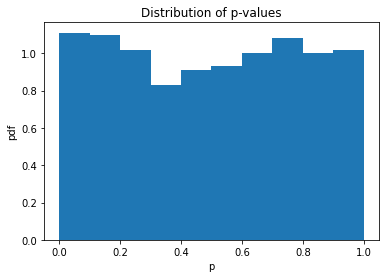

#### Turnover histograms:

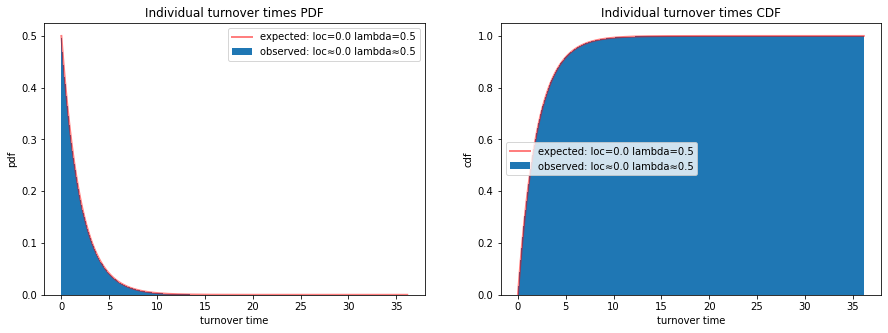

#### Parameters:
* seeds: [  904740298586735451  1749599954665746842 14691717946984969671
  5230911919029155935   697549679461270730 12421921950939735742
 13778512395644739047 13552724265951755998  9354530957826600230
  5616567771982968111 15654821775948968403  7584900048229488031
  5489413335088277902  6343420672391523866 15962335894460592270
  5089776395362490301 11703022143039556807 10440740668716924133
  3281846287234449720 11336068518743553828  5068506795555496378
 17323598852454031571 12193955358182433418 14076701145133200498
 11063158960371489299 17382467999349979575  4325408762047448271
 13462571557227479558  6820334799027861594 15350614837953823905
 16663579265120675440  4512532942162404600 12172187827952477647
  5127025348960988945 17142968914768233700 15630595682980770374
  7391439129364258220 10326719743985554907  9945398743123527273
  4485341138470258334 16404601117057880286  1881533121135075495
 10481007687881489432  2918711655197546669  1122082512656285182
 17277819210460843196 12368518255684374008 12646039999359650174
 11610233314974273404  6609307345558746202 15509678642171653279
 14651822566599198936 18086174557607457814  9667706006821139128
  4455271709342833726 17818951244666293045  7299674399562594938
 15858277005677012874  7439169427013950894  6592797956790354083
  5032760337229183257 16630632781814576486  4453762477240604086
  4484202491949681692   401306535128690911  5608107513731992511
 15757006781807884539 18255024047067928812 16134636982187072580
 14855623644054619695  5534055191947001318  5610009822645705828
 15216488474436648999  6601541430883347375 17218159531587271178
 13925379292813843689  9647289128857476698  6763248896666260319
  3760536131606099062  1845031341424329135  1386137051101975360
  1880400197984942511   968231345064114292  3200630712194520366
  7506913416139873437 11587603368453560590 10156501696795352930
 12439936296696855948  9373833528839226395  8303564881862434932
 12724398719587368572 14714678509535947996  9166023364005995468
  8306061868144382189 18321376541852323025  1125859008337301511
   753637463392494401  4169369759789779702 12127221945924046170
   532094370658089295  4118899891960251361  5374803963107084943
 11577333572661722895  8360044966507938274  7046136814098699318
 12530737333589310355  4726987378852716009 12276342589202931622
  3900927272086024018   167456940091347424 16053119546077097301
 15034942087757919797 10608268276087584355  7329116636085588678
  3453805700951957883 10475757547294551198  3079830584644568120
  8615538449435896074  2824016895615905624 13482455827218649753
  3282954399985490433  8500193773217126467  8524696926802704972
  4084151183868048146 14485614492883567762  9968677140160029428
    28572286161812762  7582558651318627801  8937656303567557203
  5908517946606219262  4499532652311472414  1096371395367210392
  6405557100852382180 13318640397753889455  5617646160958147397
 18264816679713569868  7140613866145381965  6939746109068652223
  1593029283587658230  3580487241207505653  7739153700832147252
 16864556318329546717  5658848563224661191  6236174766947938655
  2246426771378623359  7876213552226298417  9504461425216669410
  4314120543131898992 10350306836433247432 12681779596304635782
  7779620711672005267 11161175279445033235 17381105560337281781
  3615597069580332408 16529581191759244335  2380330044489790352
 15868346972970420235 12191013095228699579  4878281536600227409
 16733211537055856512 16021138567792098643  7884605143037392955
 15091487108737735415 11307560336338197108 17027988518311916564
  7877054145650518851 13760018317515662919 15908023052203633495
  6989877234007271405 15579639738265845606  6827682335947114342
 13176637697173712234  1018006589601120438 15976955651333261578
 16427208474890942019 10723377504052373988  2597433229726315152
  1041387316735707711 14764361845617792073 12360640911951259397
 11995337850075900962  4857614348205057382  9272717028244587969
 18016219157265636743  4973372481920049020 17100068131610510872
  5402654287626126610  1743676241189401727 13918900652542866762
  9034007103177374393 15285740491375407882  9221002668233976396
  6835172502584894836 18418912419063177431  1585292853744261934
 11200137607530497264 12607338414150464652  9434773883545480527
  4313140061913725212  2022314175197585994 17733229421962505370
  5429072444171542062 16716446222072465005  8451794167863261026
  7999549053331182451  4394913104152284500  3702851652480655567
  5134828796048602818  2524465992902385862  8687296565909858630
    37301941959966443  2902344402701828591 10265688988702578765
  3197920784247449997 15766466979838431697  8503936771731805022
   482087305766332956 14985597133925292760 10075604825055333911
 13732028590479974555 18013325347084879218 14490706439518020809
 11310838503525195685  5118265847017656216 12169244627044203192
  6519731880605375800 11194937421415939334 14172954525127786372
 17537680609422426301 17397909117289477668  1245938837703243635
  3456230438648697662 11959529840846365564 10870600406142638398
  8386633520728472097  6176467404330334013  3508048700603578513
 18444029868399293567   268733453450986635 18021725085734169537
 16971259748571307376 17185993945114251871  2312159818844928330
  6496145546778498990  2383546682684318935 14673105380196019809
 13611902481024188833 14199521496415851897  9876662374981855858
 10754030790202180013  1024807044881035000  9646861435195710563
 16168099883436703453 14319855162751563435 11930530413014261769
  1946999299612979336 10208805248279849356 11680463621428217286
 12135531804291966571  9989625397236448177 13578514316545011552
 13605438255584430097 16161380039265034558  6055927867937024127
   971536634885419812 15035100482796633008  7429356189823734396
 15274866864616486926 13405369729825759616 17507448308758069934
  5280982495272822655  3526116188880045082  8043707536259220810
 10876653627050757623 16168989854157699896 15074633294413229921
  8636874584958186317  5158789712371270449  9956863991954361903
 16005348689933289515   708519683439069191 12183847452281508921
 10259846925756640661  5172539425470243827  3506352505251709127
 10484215551178055761  3149422379464987038  1580999115878247107
 14484640176391743685  3005179525625905057 15298743480745536052
  7217106973297162817  8697168048341098231 16096800671189675582
  1735206951669468796   775498500515275563 18276296818288951882
 15866597334083129980  3152631066649860203 11775436603728822898
  2332759670052466878  5437122593039336257  6331144114745256546
  4830579113054343684  5794448435507507377  9307181967347983117
 11903846686870193409 17489000864509859666  5999362681375269457
 17206707854872578992 17538431476687268014 12277317386343413193
 13004836849024184197  7020664255500575303  2878201930924307755
 17966664392485830304  6882892924645497889 15151738131951129403
  9614584195522960929  2877343313877140650  1190691672646548396
 15525068469210677145  3723047540661535364  8139633059638025626
  5860361975297189391  9719512339587870118 10821656781891073647
 18398992842940937941  8997824016351644803  7059743011405155644
  9299624514997443191  8078975650770827725 10121479667229424346
  4516298335420916439  9738640262620106723  1350104837611794844
  7603999789373797811  5111219729722038037  9446122578397476949
  9862151658652675040 10489914467226822653  4049009134316614903
  5112988839733777524 13318941912409139372  7083105047741012031
 13253096761760560792  2936747322653999319  5939249736271787364
   357314683347504170  7689395693102360214 17148224904975708071
  5915925063338004958  6942077218885881420  4289507727178462495
  4920473940799802648 10047129458804665531  3885261487360817062
 14605049316452430280 14759296682176922781 11064260783585274373
  4115628960171584312  1427577116288750347 13869188342965523593
  3470358772137595623  5439126575276295285   549513516215179798
  4563859332218387609  4055668072358541083  4299554753215960907
 12452106087012610028 17891400670320635945 15794843592511870855
  2993188800389125987  5044142169857603315 12826281740577732168
 17426567942492163685  9924120405863935440  5888716242537375961
  1115380889859114416  6451721211193004297  8500670285313910793
 16137629788934308889 14894158164926912922 16564776578205792031
  1058134560194834040  5724457336183665276 11866256671453676148
 17179109779685458430  7204052680396453665 16529042191879149653
  1901283755963851959 14728293201746698300  2057001738402383407
 10260165344049349547  9378538224133971153 11101577180920999059
  2761695806993049438  5409901908905282767 11031479612713989527
 13932671654075161404 11328170128921801349 11742612797351088699
 12331287472854297807  2437581172281690766 12927918297343672411
   290317583384148983 18366231239847383067  4339073909288235709
 14713835336412118221 11789375223445055860 13739903032499141327
   901841638244398088  5801602170493330679  6185189250976662272
  5436457521057532456  2710765513882530323  3308182696335487475
  5607568382353981385 11393923079657633722  1361423292623807251
  6725670539853519119   773537808019820891 12589798779889909988
 10341545985212186598 10696219896600901115 16476372292068290390
 18426124537795607467  3897114956621362775 13498579753454753856
 14979569182432872066 16666401245828201929 13492353154725942451
 14842619754025722778  9733209821398206598  2648341444340894547
  5998467335132073540 13960794463179202068  9353668675394088053
  3125655972467371887  8678329651339507057  2272068784909611889
 15085586121711721716 13438891518008469952  8369877228991846172
 17096712288385360305  7941511600801748389 12430949049770580921
   304040618267524398  1446068624463500554  9437171435557739342
  2620748153643812221 15062427154130172458  8953658376373978400
  4948606306145015611  2611291000008430808  3165980646818813276
 11738515586846160623  4388769869263416275  3066652122112758061
 13893831358168345035  7656052288746027979 10706586601791520331
 17500035355489879489 11795081003544152539 14801366931518991466
  6310634766801566234 14438473696426675600  7131343744526634940
   699853019890747065 13071268335265593910  4844668736791632883
    11923631706521309  9944130038978937188  6397164288149027819
 15556547984862155695 10948765559222327291  9223555909712841498
 17198098803809191018 13389328726417770443 16322445746707655484
  7240556257203977939 11446661100523032383 12771390942728877954
  7523924214603933276 16877217148365358847  5768074099440223775
  5643526025133101034 12022352780398307300 14618684945546728625
  2288233383203947514 13055769280991827236   951436960078641452
 14731304572215751948 11517480629758174007  3390615662567096340
   385756806853020864 16132625252112731868  6958106979913208891
  5117304996551071890  3343156885964634234 10058752703920668939
 15875375594639324331 13633470055824622837 12636654829942415721
  3843212766312477234  7593146580898664654 10177870207318251415
 11314710108193799337 16623319879430957524  4330403392402953547
  9118615519278927532  5623771890874411015 13889305249385465874
  6256104149564247041 13599119907964974796 15564236897009038931
  5625443390058829237  6006790686438445932  2884376799407977707
  3408808735428281981  6251005534651335367  7303393196539636936
 12567263483400955056 16949927039964254791 12340886804834077833
 10249552636452105937  7050251303627262443 17072881184398147712
 16263335355400218484  8493966769953532210 10241888033873015071
 17551563149459516657  1798017210658916501 17391948923774002488
 18210047998950512330  4158295373298367455  4102645448027843695
  7878298584023524612  9149030056296706383  3225207699508040098
  7431369826620626561  6883787409551213621 12929233312112540621
 16610945163201441793 10819912480988423189   937618865861851149
  3663231637427868287  5528304302049715598 14569351125584371154
  8745837525561396109  8815988975945347360  3649287667834000023
 14091019746644090627 11536003109646782907 16199604945772820187
 12796245330840595011 10115881759244762534  2385257991184445422
  6715123694272339566  8669597040011983015  6469159430923271005
  7140754680327594818  7914172902585606309 16510940392439543107
  8657146740584954152  1403294538355601882  3719664613238298969
 10293968847079534468 14136842297293210748 16282004351293389234
 11605296195958500515 15247303309010339289  4926994776482015741
  5905555834687132547 18388777504144580356  5771559375791105166
 11522526733465886272  5125713628913570695 10960701332919254135
  6927960734401542626  2595838841929574675  2060012600352910763
 17504579571090804323  4240617917516600745  8769509516743802992
 10738686656131454952  1800234584231581065 10102369411930006099
  7307666622122241690     3208812518383275  7789698144625559439
 13038298272929888920  2054499452558913332 16951225126064281861
  7848769363043999748  5923931448841939594  5795390098548207236
 16390288863040472695  2790897476173130741 15105415966632873580
  3156849001128484220  6312240389902348139  7106645689852087189
 12318090208227042340 16457712791386644680  3436536704171112204
 11701074122396620966 11650148588601463237 14342529442005161628
 16355126127489135412  1236709450001616275 17411640833679195396
 12305319343127533665 14667224735309901600 10987865440612732134
 12523399967753904468  8378975824318123386 18061822712835562890
  2256807290766902633 11472611234067636368  1365959915335677412
  3304654103858992728  8627556068851904471 10152487079932890687
 14436291567526120701   441429700457598134  4434086422990295978
  6224681354891285151 13528354707296930933 16523523807287614625
 11483494590932057142 13998336618305484172  3338559062625575376
 12567854012407576143 18324423198911002033  1238385829774676557
  4540471307060706301 11879307760849999606  2972745196721928611
  3082266844364982189  6444161023529468321  6434497826822674677
   894732136230149628  9098514970961142556  8756868903564805533
 16474010911566640913  3150950520036416272 10443288135289220686
  8345326031197327000  4235072409134572419  2650035486442143270
 13475439784128324162  7501428685323849954 17750040934625876429
 10511405968505944956  9918055317560110046 16855120912092640845
 13728489505874033858  3955029344741948688  4890584050703346769
  1683164790562533280 16540220348706899349  1826633189887753916
 10175425909007321418 12088037880697174912 15191476349287290834
  1471908541965328955  8634252934048930622  9286663054264940373
  4222368635268393269  2810033197490553894 12775451069898109939
  9906061950727424592  3120056037227176106 12916088517082712887
  5673581784295069669 16001060822749379058 13489264554781208132
  3119493395959956093  4095017412694929500  4409256218387643436
  7546976212096219197  5261918008172135486   335199885960350507
  1271333629687764444 17101216085413753483 15370729586751901593
 14331942437863494718  3681437169242850473   240145988617533669
  6108362973597879790  1867898910762445925 18431158362849307616
  2372922727388413585 10081045456452461644  2022265679132521511
 15368151663415864734  6253317524403861365  7224451221657573369
  4824699512652624621 11825971101303621053 12559451471011178324
   965960939692593707  2613628491185129291 17858557191049427166
 15977868075819908355 17739980631007960582 16859602854697476628
  3715844568540482814 14309784533061365607  9894652412175241970
 13171834977499755729  2572924131980858901  2664113437956471694
 13386219608206003303  1643808327501013089 15269418296336562027
 15916660608012062931 11381835689840616742 14115357852749628476
  7465374852342983830 16350308199944547680 13817636416368054718
 10928351253467709172 14609751064883175663 14709823340488568483
 18365469348469766695 11484432270734498518  8157456944581566050
  1623641542991147386  3433657029071388038 16314657201100438810
  8455771750137594394  8198560506595524298  5915807482190221230
 12287124760246599569 12253202774561639635 10523147252857101409
 18439300704549532882   457739125756967386  7404862282051411746
  9321648565730861803  9817784082780244634  4388910940453855611
 18319764018372201773 11354776315996605885 13389711749694338662
 11040894066515446960  8845125202669806736  3998280285216494336
  5719634513142931485 16136974195027601787 10986234327652045357
  4166087284775323015 17006728867707138890  8399865396503872298
  7542538717788626361 15552139505697171857 16251735213902301809
  2349243173123145033  5652299627685779064  3166275406725545221
 11289964509301079489  4166929367293651459  2101268871023739948
   871218906521351732 16827028838181508044  9737015006489850094
 15460131080835663437 11719697932441779560 12422413655672735519
  6680982296664398890  2378994109487473766  8540812383338221255
 12046873234964121226  5021804293323732708  8748098723731399102
  2530346933235941240 13246730154643259699   568800777645953740
  5544190370858648818 16470032815182904328  8697937766346658387
   722492258071730855  9260306688739151377 15188152013053458144
  4393876440847745676  9622222310393825022  6661299862981331168
  9043614362473351681 17914768788608801884  6629192479480777580
  5657223962036870080  2816230808999589129  8129214361652191947
  8267240769269041912  1675287889452350426 13775817554733851698
  8574613910881224435  7669293968981215194 17428294594665534102
  8772267739994262640  2849382661094467313 16568306591069149522
  3339139336289581483   172916860435024062  8000184230518017658
 17513124205441088916 11485275216902937100 18273230970987176905
  7966961362067216626 17947782341964162662  7855007725541304344
 17683929076954098057  3163299709413275141 18140326027410487519
 11563375446595096005  6490548424307649192  4523730981726027180
 16466341700301300784 17459698128548557137  5884365542607884706
 17797055242261089850  5216724390204331382  5665819574129643298
   454579533209988903 13850996151283551315  7126734999279509526
 15653691745241667175  1641761505373580451  7433954249069426249
  3871006390020863749 11125901899749161624  6563174163762549686
  1455236153723509924  8180805405713258448 14922187666631388365
  2849541450772143400 16516265743678711159 12522384269290130757
  4924943478541017943  9888924163545453149 12409636301008217656
 14802113651808239857 13656147803401581429 12589571126265458665
 16528524546747780624  6037466756325714234  3456656095791891563
 17840121258082929480 16989451866619728842  7568134051122167561
  9582815820971465665  5166549876514372272    60794732635060225
  9382445254475647157 15429778397514967471  6021371768199281591
   780639196481106529  1486175915572803863 15677712238379574181
 12514953616625680908 15129920841369275838 13018870094194419861
   261281580089766027  3206520466810781520 16326162289735776441
   283319952427185578 12299200890063288068  2363677342768771375
  6030954891850217996 10226747413775416571  4852188399111939502
  1141891421288150051 14025812520568799397  7395874715268633723
 11643848256308510705  2627565249740066764  7847811501442174303
  4230804755697060926 12455225374926913629 12251135889883990171
  2754077040421858791  1962221719711095378 16085769074692823309
  9973045024953661473   932003497556882162 16901041728762750891
  4204564746625617644  9552827221511357809 10477288286113121952
 17857292930238264946 16627603031686460628  9067471271265602275
 13411433999794704055 10923946559750422955 16180747774309295871
 14597778227685989440  2569165617015973788 10410209658896074360
  4799443919343076379 18005541825594793953  4684383270923471997
 12299048981111565056  5641995929544656034 11759044020615591912
 12191648580368042649   766200353813520035  2552174677423233342
  1943841160615941581  8880945119190223875 15932589646067456559
  5587253634114571480    21457104124332030 18222367677143163384
 14678933411153797017  5584783878237395799 15644827466316352046
 17561990319062024460  7726489931974216251 11845067250924406659
 14249883930284441616 10679194394629130270  5898346824806290606
  8271372208830675969 16387398143808716986 14685685731812965941
 14049923606526097266   919647613460038944  1624639791662905896
  2001982145938147200  3761821120532285868 16910086244177152696
 15984330898230321413  7409078994524822832  1944530478436521887
  9261591958381290850  9893726246136590724 14309214996784026592
  6932505941442591780 18278245141360101980 13424197698149152284
 13869356872256173020  6780851249554586494  2143819170152712599
  4161879479704317786 13459128756852394615 13549829364028223153
 15769568593976413614   141789438256035442 17533093734731348956
  4909306624621917611   254570898101440319   423998386560306834
   505389825377259669  7139876464843015149 13514933017969281458
  8874472806126362986  7371478530189183751 14812663638463941242
 11937351506011870762 12013173092783698111 13758337598961125683
 14916320812439686363  5422671963501664760 18275737605164841590
 13672088925593571630  2895335798862314626  5100695600661664354
  4736161831083359407   615874733655220649  9932547059907987512
  3467557042365134095 18350314984862837363 16519212771072163203
  2952792992423443462 10541664245211757020  7712957302501031885
  9775338305854344583  1232542377298592984  3498681708345378729
 13848902575923108841  5862234221157824769 14377791012543063795
 15416500831923982118 12303788449205119428 16476786528576195572
  6391423886487607235 11489308006905208298 18190072280342792827
   511524832106109092   826188822979170806 17850700029896295936
  7224335017440437328  2558903669010790412 17734349642085405527
 14286681700521551984 15589798051171587932  2602513868395721659
 10533051940839631741]

#### Configuration:
```rust
(speciation:0.001,seed:10533051940839631741,sample:0.1,algorithm:Gillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.14735319138436426
* statistic: 2066.326513601637

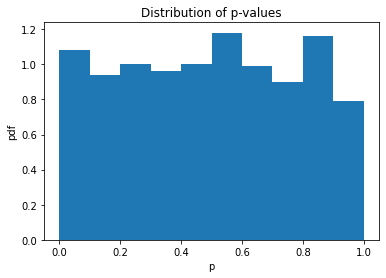

#### Turnover histograms:

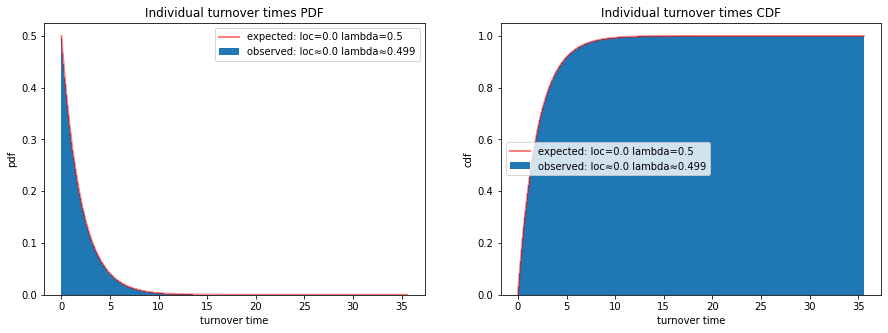

#### Parameters:
* seeds: [11472669967080571561  3703676075139722318  1767683258430683321
 11766933741503829510 14202631408020499339  1769235192687362110
 12650212427738602995 16240010846084915612 14409196731538621539
 14423683226519007074 15348456315093778413  7464902391213119527
 17881412016285160157  7562628712635728195  4830713524911201148
 17676403325766513939 17658816939627038999  4856968826277239001
 11164865488458573014  9794830708634103434 18303410005038765611
  8918233011704564900  7849285049244933717 16183903443043815977
  2604406707553155862 10141661239530742083  3025677916624082144
  5223137004489237931  5319760668290257999  3690888208510469906
 16899020470666999318 15823876443541852841 12577698539556644202
 14840163385511908618  2302832820765373918  4715930213604941992
 13054134362615216351  6173946251749008749 10053914229848239046
 13589238412081163435 10371999215219852152  4515377502800052055
 15098470267453488605  3372400276595720192  8005168441052650361
 13963509530575396441 17620073711630462643  5976144519492278029
 10942395108247225224  4651959141054109858 12772835307655222906
 15752073260492572073  8980083460838446751  6616639384880697823
 14174742135177815293  1183628504612065714  9299312506774230439
  2618520195360827126 18441836797952762736 18415091309798128857
  5250331046985900100  4019500155887089978  9537037306465737499
  1722339297613067726 14163570310899554325 17263980757964250062
 14028240651979305689 13607619771276866016   819883493596814681
 10633773622531192275 14846248502240837692  5987852229869762252
 13339116340914331747  5649516984738011841 18109471733868480451
  3089577759271453663  4800513820728996537  6954995948023994267
 10758736191370478070 10667878848225305015  3017346401152177711
 14198339017818562811  4368822398483072185 13819713224397831424
  5210630635934064168 14256561901150578700 10433830516698089397
 16032595789951526180 10252508021606984895 17527560460161305618
 14231202608297179669  2729707726945996266 15498644521388754630
 11660468417374561407 15985351787123023030  7827962628662228106
  6780424572378809878  3152860026635248220 18126942736059851081
 11750084664474583790 15085600349163507904  7722349617689156807
  3379827946809607713  5625067186734134570  1698631897777966367
  8979222893915558374  2491638659980600588 10325121816419304115
  3942525248549610834 14020401592943824644 11885268318072175941
 16905587419761191777 13254938678728116757 11339933962678841273
 15489719228731109348  5054186248569845761 12023953198897783495
    23041921985625159  1285281037526410118  7744502961390102527
  4850697752493066896  5775470882785984869 18289246500792677371
 15251700932616113634 14920951197298754931  5112962377070195308
 13418100066389281584 11703331205832148315  9078600135918422222
  6905645292863373694  5024951550021258570  9503629564787615681
 18004737735783012242  8764187991127890225  9500155079979082192
 15887835932249507751 15366729411202688836 15780750981075134891
  2034945603852198266  4790078198954562699  5220651199212368075
 18255906113106251792 13068438820020106333 16642280974799857049
  4190959641795634771 13908951350326780632  6214910788385617342
  1046366506832771015  5679682418354930063 15659831725272787178
 12981910055473569418  4126546983674291940 13887149339616619749
 11306932208491218559 16786302322825359560 17338203348570798190
  9654855555808701750  2786810209716443207 13064875873927287783
 16743551896068632285 13030964601243113684  5419697556037396414
  7523008025762254693  9626293554164997756 15158000950697316477
 10321545480626609708   988612706194048602  7692496075634373238
  6711604232356643271 13300484696368021149  6994077258871020446
 17463822663039427697 11884797732710304840 15879364729379957324
  1998323610717976926 12793967492602572872 15190508760066173244
  5618043482525718971 15121675802192526330  2005824259695203073
 16784113678209483566  1772707792687092415 14895374143400850082
 17662691607791726981  9603168600667720187 11369019949483147959
  7381892135520041883 10254525705829251612 18257999011700057479
 12236503134448918679  4700270500192812046  4459181069099184924
  3686997928381321255   134038859274732511 13800143095040712580
  1723553454153216591  6443951482813170743 10237945565503630669
  6357514295377440325  8710170767481437418  5169794882872925223
 12016045125559140881 10173211715875549227  3906699193342845727
  7920648343432140981  4616297732255545826 15841357475623118436
  8518744915560202187  8722293774502724028 15810462948443829207
 15514785886881127155 12992873715796714517 15413534174475570568
  1716467337192620081  1047006526545561191 14357962115231560806
  1701738473248930454  3409308634783737125  3804175279122152923
  7447223298972464916  5989434235891696308 11135147256308176871
  3538544584324910011  1331103782611580850 18282066202827277565
  2415923447315939959 15853891379537142106  5122384581944528213
  7731790138814474326 14463328185796373050  3575041412352202187
  8492557592118610238  2333602046123452901   649813829977613468
 15553305618257764635 10495163405552767191  7585612070245713961
 18253756405454107187 12100898277038020079 10969514552529087376
  3317846198055376641 17923539814807156517 16722223200513632990
 13549443562761628030  8580546765292767974  2385136086508565158
 10227977404650457427 16979579851257505367 11144258631678924027
 16710247369619599392 14039309495532828184 12101529962242889741
 16607277839285172484 14270952942740541460  5384425733332172412
 13353127367840708171  5743874861523454504 11032745964831420624
 11138607830039963831  7253464953088381277  5359427107475996390
  9036429547098738888  8497052383027994707 17645393712381487667
 12072348455832712183 16182982637230635659  1864724067757727202
  1637164711669134915 14018427250270463081   635007185228869963
  2493559170664954619  8274492526489551798  8284382876908734024
 14574814501506528593  4978891905643406648  1702870515153371696
 16088424989453440414  5491593735543571744 13946256229154789104
 10232840548596058087 14020970475870628992   646868838469821778
 18273787463305438639  1343231120701489022 11500791904417550355
   949512793287676306 16847692479326866830  7014180658397036850
  7988211359671586358  5569095943357155638 15857130066962471267
  2397534622431446706  8573221228439192773  8591671375050588463
  6692473891598280130  3571712277171992520  1299251961082506305
  7598719441681039076  5602880289281503352  7842859709987552027
  9388593255797430180  3680087374244883057 10921184448638251925
   362797569813429870 11172202017775448091 12653702316369761405
  3285081013795011961 11383721808148815331 14149354705905478543
  1139351686883703263  8608995857207319720 10120392661719026481
 16490051390216260525 10068702410019967593 18131105383221733005
  5517873590073703611  8032890723380394881 18294303454186677713
 11258455751201916259 13379164802637912985  2198433786363821944
 11726026740745470325 10633785849338771172 16098614870784686021
 18194264121924783137 15319961037747715630  8961470382313017222
  6494103896080957249  1580969643073100978 16858579388805400141
  7258681573827334459  7925439022871156310  8725582777138457205
 18170415942494347564  7565385438905604627  4885938066150615647
  6498903832115091363  8369128912953111246  8558937379553975947
 17753093211784901731  9477839552245810707 10754039293447429515
 13644080577799939022  7369186669538308550 16913224630380921168
 12694676786427829721 11157668043831311812  3117881599260827450
  9677400032389126679  1092783098618663717 10442041320468030660
  7516213232447330742  7051278722934156554  4199102768332942871
 14176447848453172583 15537321231252332895  3544973885056355481
  9490220964427118329 17446246444600983428 17723765223227778895
 14710435911937038850  8623217414019314189  8925170191637261010
  4066369862437568483 17117320856010810981  4499351274837393346
 18128357036155840028  6758504487466362188  3069407222691588978
 17818015501292103814 13095790527070083582  5120457100358849395
  2806253337738535053 16208641257675437689 15156384209519522156
  3850214061010093632  2743937411644658728  4424919541209908717
 15458184088939775613 16232466226262391380 15031266496218064325
  6548712086928164715 14615435766211791463  1719039282849742475
  4154501815676787596 11646802897079105685  1637833892179099274
 12815925687629422806 17843475905709204222  8099290318026118109
 14945643276476483213  9144680947663225752  8794823793997665332
  7728673552968235180 15416355348446416608 17504567820119219777
 17687076576602065626 18060429827446363336 15793682275470981021
  7383055506705153386 11654509594010861089  5235657185566632397
 10703629352688893152  2847996474052303731  1546582048467258380
  1872233374634263489  9869378811118186514 14174500913357818284
  4508997859262768144 11479502387069967724  8131615882714536380
  5465826115952812595  3675966264539424199 16065428054524563632
 15317830515625942768  5585607077926194434  3926688097085511711
  8984779537870841592  5119362236147646003 16787593304394476182
 10192542423309882851 17948507764120120965  1812976081839938421
  5527438721756925053  7876122012720166502  9381373357393969094
  8690450475858012787 13614942251578380379   807891879686603404
  9601708676043672539  4294730640310943901 14029998782595908479
  7018092835719800897 18414390682850621171  9459191646049607354
      746398389077726  2897091880486631542 17579409022149545439
  9946261588149508203  4744388023074042973  7238279589205725096
   109448377540353092  3978190625633166740  9421927394409415009
  8877793276296001013  8165759494370677797 13557543877581685518
 13495261540819060602  8648437994235377910 12778517505770384228
 13690074643556077144  3097096782350765760  2303065040469777735
  7869636315711665940  4257426150478384027  5003670805097059036
  7680938651270347046 13947841923728956839 14794900726853026230
 13462932743646475870 15069339004956952151 17111865604354343573
  5532077316113655073  3291561002802945877  7511240811695880518
  3370186958227447419 11129228114539638379 16449248544190526517
 16373959009596396248 12751407332091781955 11753840395189681773
 14940751719786931981  4277454680711770106 13191669324071583701
  3904032668573770909  9972762819033882005 18307738964560553302
  6303404979491214966 10608304590135063262  6422674446398411000
  1516415108844054944  5472876693548400978  6995439075532323907
  6054052654972828393  3647020948076934459  2130394355488630351
  4120278440656463623 14422634890232011170 10613930679817888449
 14532269428354002279 17531146869723122759  4190625944718073428
 12300531110565739482 17338072554516215570  4488542828451264739
 12164830357003011137  7192394652757644143   347017418300333642
  3524415835810765840 14445224735289549437  2432009601927290849
  2352595038419947091  9187522002078370551  9169080493560721226
  3435814551989992016 17008642471586453375  7095258885898321295
  8527870403687180187  5556424332341192052  5955705732174744630
   275979708362407647  9873561992201816276  1601965201846224580
 10709314471597384579  4723650888337796506  2180830124150146620
 17121025698267540633  5196528660230067931  2024996468639385256
  1461925323605447156 12867256952650021582 15325520984967271261
  3206777270182054875 10300492435825132077  1359422293435005037
 13749291749592274140 15526281931369921252  3496843747815172120
  8817104544875855403 11307143872617761861  8451469167937836786
  6409773151004312563 16057098906831354949 17000892469917184172
  7770477165581102960  9216075356272529099  1671472826957725901
   236342103164389465  4715125542666280788  5183805208779743035
 12410585259558099067  7447390700011644655 15782865276506912723
 11735437506428572782 16754600806971986718  7181895703645213966
 15600491601589941202 15431907977994730577  1669631159585983854
 16443278877059417682  1618238049292723022  7245514323149347501
  6642017349066556695  5472464723283898318  5370845906920245012
 18047859527981051481 18094366799861026716  8895682752882285038
 13263788316101773860  3114200075175796494 11643630875516369531
  5945884832576240539   704830048072250291  8204912799078244158
  9801226342667787539  3774402520848098969  7345448398818751501
 16798299656401411522  4151269832050891884  2093881735473280373
  5288060164144367923 12382207116194577225   626450297428010516
  7365382560533024922  5877384717088091269 15226069091089099467
 13567568219240728998  7601252530370183407   630324076284468098
  6939020948805131914  5903576719217465276  3850102466261446105
  1366713668767452386  5374309024787198540  7754248796173093857
  7637590045714075195 17580331574306682737   757475027017471526
  7049996728819139362 12244930194351286793  6799859390092852893
 11615258154238189086 18004846434564282552 16530492158060197923
 15506651287343524485  3618192498183718616 18079362925473778590
 12354531894488722149 15041519254986105812  3890664731861378082
 16075247740766374645 17308102841446265178 14617601112488300613
  8043159405713095174  8357112620441465455  5626547631748524585
   853543859267317816 17830198206641367536  2277139544596583472
  3253081176261123594 18197155238920217821  2251827663737854466
 18306581997698665415 16696782016672101340 15077002182824111627
 13066214022555979834 16126241520186671095 16965631337453637592
 10880709684509554376  1118427449097329221   383725448970679486
 14472900147115760504  9496827742889477224  4681419244258205624
  8060293263174388143    14080695989232677  6724314807060274354
 17035657612240392911 15086714065327055601 17108061921235953861
 17249743628061791864 13137639611075708657 16095559836865193307
 18030090708340417613  3613992505272528567  2235930943390755758
 16646303311569162825  3987100894724060259   428622313622927703
 17850194135324503991  1979736778029040798 15293073642550258863
  2338586901902205506 11516239006242548949 15720542338553470711
  1875023697860630245  6222235464004041653 13528982973558223927
 15178367916811616148  5203204989055167969 11847525401166361369
 10499260667234440475 16447748384746280790 11244376580141754397
   264654400636083563  9046680978382572196 17422916557296343063
 16111068379310396176  9643279942719858349   706761122011271032
  6512542868699246088 10032438645202031244 14065651231454515678
  6733077895169866680  7138072225577675765 13201065134750093501
  1131435653510845217  9603209054955628431  6052867167868773943
 10854868677416394129  6089276716301893041 11086242341795545118
  3465319440621930785   514588400313389636  5297798070307732828
  5873559719096080091 10036120151501727811  1316711407000398133
 11637988349930922819  2621941825708918602 16918410392575349081
 16290190854975900735 14126135906346369044  8623363951287945899
 17843464650596853390  4528422928255413975 13036373639348468686
  2269669629544882944 17960743202928829057   688892542076562896
   261288134989667039  9022734450463990703 17516626367981776004
 10006284332381252972  4838283904381349932  5494058266688347254
 12977770540021385966  4449286925334213832 12066519772819583082
  1863057094794878888  9765613166339396817  8959929219265367343
  6985251698043513999 12160164239814547384 15926664999119471477
  8470556912518428896  1453184161073067553 13169560012853581624
 14841719517623286037  9191577878235963359 11691689690770234669
  4351898680452218859 15720460375180961402 11814071828084738649
  7707046332782049478  1658931431634950096    29655213569926731
 14350860696101174934 14269038553356978592  5599251407289911936
  2604236742245594968  8333954261655554943  2763226074567652925
  3755354008911332752 12436454572930290993 10625737862647174141
  1308457958488451280   707443103140345487 12313215926309601033
 17766429467387581803  8142722922434899084 11464445404888406085
 14691111387218076466   490835963864673697  1791766325840852580
  1294688486214044268  6643315655784483614 14092162915349539808
 17999320802268613824 12393353971118104057 11054441477790449018
  2193989159141580907  4401429022921601331 14000599636436859552
  1380139031993299261 16134943021899919596 18239510825036752797
 15329552136685401513  5581718606312149010  8359725264288047958
  3563891499237833896  2303605946097110099  5085974408903191782
   703277898342401037 16629976031639711017  5941174988712261007
 17720099399849775703 10466813127036513219  7606839946628821843
 10301668893258905274  9337374714568100822  7653018468550402324
 10241279980738136390 11062159324127751827  2626421195179499579
  3879147056834498108 18282144787628174463  8545717188412999461
  1895905148856176714 15728016012529935773 13792108661778404243
 10932084191025355785  5303290070379057941  1942565038340963491
  8693798564139325448  5090250237202721286  9381846645512658824
 16824531812246890261  2271015076072083534 11562970654724437893
  1553799558971205202 15806531711742277027  3673987139799633034
  9866973062391213510 12463324818579010488  5971080256190633284
 15787548758847451721  3475232945459782288 13272711221310264683
  2882609533744684301  2594563978591944566  3156421592024596736
 12058900518480382083 15557153108241428712 11304867607118886051
 10410271721927261111  9143014824733006575 15639547786179379147
 10371225461988035211  4026698019377396400  6222076636498635868
  3360535875515494506  1201754685702191074 16277259869532971962
  5286233741925213163 16655324341870472745 12675654286064916338
  8825001220392830899  4659994371889174415 17584683929474191272
  1480880416757465294  9498379882039385455 14167826186380123731
  9198994907823438248 14668335940064326503  4702455216015254272
   785065688760612842  9436442032581465003  5934923538630533425
  3532671997701049568 15555598368011202361 15809663320596134570
  6517862397103436548  9562266412706640165 10989119720409858234
  3701509958804056614 15940523196232491813 16133998492723933698
 15973488805339841227 17441903587915574017 17079063137282927521
  6946694740583312909  7413499438551488718  8715596317271321289
 15081850489673595652  8040230240664310482  9821785683809070118
   823763935648621908 15383812113617698632 16167753286477899673
  6842592563932241123  5000025353854055833  5752864952009083074
  4344068620214511618  1025983975084662779  9339225083205126506
 10696557215554191887   933561803233607195 10625984790289521036
 16447669137766087737 12126394329173782675 15998794841474788554
    94730162098375154  8574603056279802049 17618695752011665288
 15493780162119926121 13758490760082930322 16789548921237668506
  4736076053505762782  2253181762739657424  3716618590001135288
 10535188365694783391 13421394831333297287 15499729806162604739
 11507461664774136169  3024115751756171917   567605758243115358
 16433949532401979632  7351117889326847842  7177475827073012356
 13075153777852522481 16491905770168784508 10975732044867503055
 12011838153598744246 18066855666292163059 15871119137155795547
  7661269390867557293  1986349016137642637 16875946334880552878
 11610391236733933893  5150411725952296762  7861219623494031155
 13626045122937503994  4184537430629611858 14237486114734369451
 11111545533647660589 16333580052308819596 18283483112106524434
   483569429669706959  4926775445458238231  4311327490023797110
  4730269887503779638    87769406547221248 15846452535675702884
 12629226450281744087  4997612400478926306   709533784095200555
 11194302281628759402 14025500381750837928 10553424405603029418
  3903605029561538445  3943060584426855403 10060796664066561617
  2234432170555493009  1679751621814641125  2646634651548011056
 15831047555643745221  5569881538284601197  9453092348092143120
 15426112811934193073 16470419206028234651  7471662671278453150
 11577145030773875402    47809295590724208 13851928198229050701
 10524324376870120542 18298392324954629679 13865380071662940401
  5485983052359612563  9492994570607696509 15354158412043406103
  2242316045009703060 14532814445757185621 13322694857008409567
  5103148982459685212  8085790735056860314 15996048563186610166
 10784302475627228178 11788979401360160594  6825318896442415654
 12841251634552800028  3011678453024025299 11292331785376590506
 16134948084038210779 15914630123338954913  1902489750332083426
 10653948766218358978  7876341864049711349 13849404346230392375
  6826557059536098411 12616160306438322310  9441870152345573477
  8374769137120262045  3633935508527382698  8890769477568228400
  5646109071113066484 10576662531251515599 14528945233219869104
  5366719225192182828  5724581468281913436 17821866108165338252
 12264855110863735560 12607224342375143974 10646335557993611611
  7319259918912654975 13337910112537394571   929344222508315034
 16577828035262724727  7832005319686691391  3442161959708941041
 10777954968567564927 16488485814687460580  1200095106201615045
 12492976643534555710 10108102265626012198 12355167698468851953
   596678621636892817  5972019225110271983  2886715008130731508
  4667337265195480585  8437862664496185394 11093847584668048440
  7051000200513421065  6790672370474958796 15547871681758924627
  4127657671907260863  9482853749335768301 12831879126228680202
  6626606641056925929  4501773198360051518   783938570347886725
  5225959441303374015 15494613503215367865  5001989741043337492
  2582963678419732347 16149397672013333851 14167226072876749211
 16366349661096524316 18260384598605267435  3233533428556387341
   151528876070341070  7369891091178488853 17405014641813972491
 13619259020354847112 11092065197916377178  3901227439680363053
 16385650735275495280  4377873658478502433  7081799477398027095
  3199251516107375367]

#### Configuration:
```rust
(speciation:0.001,seed:3199251516107375367,sample:0.1,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.464793731796305
* statistic: 2004.9261155109566

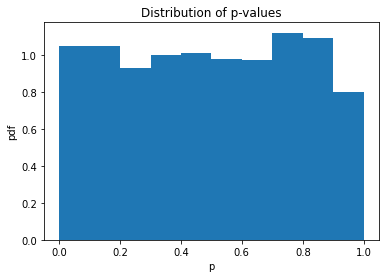

#### Turnover histograms:

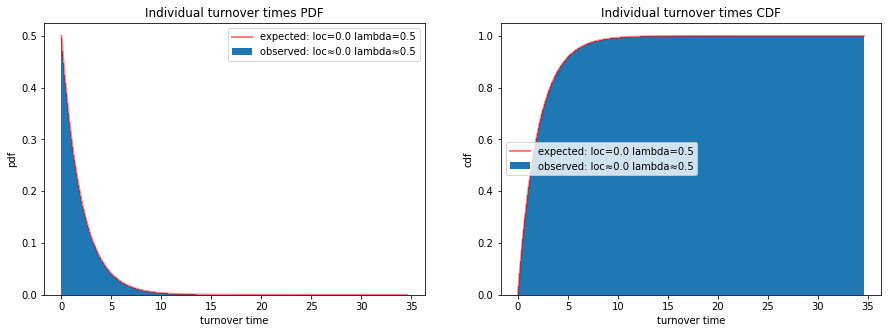

#### Parameters:
* seeds: [11537114800582646716 14103028263484320907  7560884297273509616
  5016251718325446996  7787208021826605972 15384132407313350713
 12933837253161501322 10005374959208552667 15320933528962464868
 11716076505377575004 15153511895512551829  6488370090852777988
 13855460309072931309 14397518082974070980  2875645661860442230
 10598214898694323529 13434550073184834633  3927716869635109818
   737796272350455363 16494243309247330939 12307697406776728095
  2841859262828124385 16813349092143774797  9804868860923482357
  3154287316944675283  1904996360243137263 15311259051784992778
 15672913675206860136  6387561608126994522 17174858778913097214
 17845449859558020077 12807838129609841037 12053065098073644564
 14642884361400322131  7536314966723784028  3269846041755415554
  9880119246143727145 12581423779481858919 15283899946008604438
 14234661078030427799  8524460647969864755 14253221333285271354
 13736608809733723101  7158970206043743851 16600354492186566652
  9599428263491799102 13697173640833544969  8010873259352999191
  2375460472282613922  8097097819436200068 17456683503896564789
 11887587652807897280 16027056140289020563 16946054214159980802
 15666989355632431008 14536405908320735813  7632893656312369493
  3473553205119156951 14323719229564994897  4807023509030488581
 14765074514794497322  2731583895794561085 11685396295159901817
  5580917287484464766  9411058691166934620   987953675539316251
 11923040254291836505  1430528442882239626  5757934144642367696
 17644100866832272539  1522998499726531795  2744033839001527862
    85554889067531026  6625879021027918060  4751756026752348780
   152902656438548825  8130764240884303930 11909588839417615462
 16571856335241805297 12608501407785269057 14238995370543820761
 11947333077132363432 11555545486277561410  9854075656048533676
 12237214810492094549  4298277617068351163  8209029706929031062
  1639815432172340296  1373175553639259082  5667938067175272398
 17118414959306076699 13076998744664564129 10408211389218734053
  6632840593605591772  6231544411997171654 16203591060010677925
  9351437296532918285 13795284434686994845  5431670843976709994
 13828408637534912037 17196946009188362758  4348275995141904434
  9126999656722607572 15993173819139419696  5384338955230612063
 16744405213541196715  6018110805922011179  4573991493260908091
 13555122088623924724 13376591358058379846  7832728508443403543
  7374653425099528316 15168993908318684121  3328017174049994488
 11626574826255243900  8088941677398579619 11574816454793392538
 16748226443085454809  9510818186797801165 17101602195322705087
  8274864659562744688 11372093513383087540  4100653936146166258
 16217940474671641314 10475352484090620824   586393282193733953
 15478521331355307731  8901993607657847892 10948125351967000719
   856538405843317874 14385543688643248704  6316195428468527341
 10043845152422644978 14463571332217111709 16479506723257525048
 10671606687390134423 13987340452499192850  6830053938973721199
 12704987686686213389 13296488179952448039 12793275813614407141
   866037650597568505 17256179753222164354 11133269150076995678
 17405697385621525494 18308651731773342210  2046861851409377861
  6749543602399039464 14838227015650293752  6910384064076038277
  7600842638749587136  7608600090999895369 10708648831093313916
 10948896584566531735 12692228355625575044 17116008409736477123
  5587556901497955844  2139527260743743901  1453881730913175261
 13776707611678056320 15148896739328944453 14064053258216346483
 10115893677398963755 17504699108955727560 13317426768236056877
  8890553931384943294 15321119973638361376 10608259932917854676
  2762783173897492846 12520079026613563924 14744259504621708009
 16097728482134538718  3782559309014408235 12881715767962219892
  4892610117286046657  5865511455410711403 13207202403624419409
 11554815637203852938 10779140686947730585 17062888443440553046
  6887094828056810017   273734320702126421   703906149490705719
 11866495899523470823 11769746197546489570  7137155566889885993
 12775173517764430358   712127288117678890     4337775012024652
 14301173292638513774 15192828393321065008  3722439365969079590
 17022317821858990927  8194367432428444418 17141463507586411676
  2878255713354110236  2146375136638669830  1750972346294585080
 12155838364885230702  1397612054043917005  9669717972145852840
 13356194030640779198  1898246287140152837 14101374914248088014
  9086610051450978617  5420676171028578057 10077562261282418009
 11829781341266173171  8388602913527930178  2967727196222486178
 15947621372282952852 15965753429843802008   657358288945562724
 13040356547174151875 16167516483368746445 14009467844824373383
 14273161532572750097  7899513309839496828 12852963343140324098
  5079176203235289933 16492193342445161949   351033437978429714
 11761952256610498736 12516672583908566211  3867854452520643083
 14579819847538660528 14904993807973230711 10583487460677530597
  3047700072553313928  4707212022391655893  7915562058356313280
   310433052393234141  1270753279975715887 10093950465840382333
  5239399805831343848 11345114181085885858 17037578183445654080
  9042070613785344419   253928466748583529  8550992999466946063
 14100784961374266343 18192063593905112540 15772643494814511794
  7219051325795508250 15732171306229246695 14269917893862178675
 16386385251632119614  9003442428770097025 13513936704224108819
 11265753723547342836 11903015556834894410  3272676847878430437
  7028326918010339945  4232163195678039700    20872902618858920
 14414258890467033496 12153007011895592383 13261983518710791566
  1038296302912455033 13711486971611590231  4243880525856731473
   728929891515267863 11794880634647591690 12246740467494515166
   591712974316372928 17835467269494723495 16894975862316764406
 13699846219491968420  3122654306877782149 17580094819670782649
 12399114866658505077  7209196637118479010  4916360766333498498
  9484389062632762862 17347175590278775028 14225026593798518824
  3332854120022120132  5927158511452620098 15770448464667974546
 12652777759675799818  1801470948625799330 11064685416874844215
  5196209007757595788  7965933303086346409   374095056282227178
 12195484341203598252  1645436801279116590  9157093593509562598
  3057424308611865426 12419274812233687849  3712578958311794325
 17180203293085928140 14035127522880276762 17927259799183276384
  4869316755380174010  4078534800729247339 15611000450189696000
  5591679763594704244  2904271881116382434 10984647136160414700
  5903497214215840099 14600109564928041321  5286799852595385490
  3286502565734144282  3717907258786294564 12095784305177185682
  2154224608621558444 10909311156128535717 11449198790736502319
 15605884242410412865 17400902795098381719  6328933839851282566
 12422888029559112335 12955276093508662573  3317134481514187785
 15576511489336977975   956880756132733407 16804633551266566430
   919520093708725065 10538817130848182257  4467163321922054879
  4946237255234635348  6486346322543190688  1779923311628524836
  6933726522819563793  1679720792030062294 14991584646030908148
 17580986265217925911 15444604558552827872  1549164436585487224
 12637593239363536078 13347586286954120556  3033874230443636130
 11250669106152224307  8793640159508693274 10881110956361142865
  9343952643373528348  8338375543234005411 15836858141493111879
  3392685121329288794  6542156456918352727 15391901620893519036
 18399941669142072373  8927089008266094532  2552921184567713587
 16583456027564870090 14631065873821753947 13679576746178405757
  2343972928758910819  7428713377735872138 15801834329785066959
 11348927676671224880  5975789044450975278  1565370677767207025
  1328649269121350963 15529278010438256491  2939416682335885574
  2897269623647388291 15958693275562631718  9155105381219933430
  4609043414859429907 10423859115350965798  1121416065034665884
 17150624567139323092  8936832310026834733  7879007227805360308
  9708930124443775022 14526090047233827746 13861883454304554728
   580629218667090087 11064259748790917770  7537856721696792342
 11580319710055132287  1943073778848689604  1680040935440022253
  2368068796837046401  1310613260145479610 10471667914291185024
 17274405176069608720 10891635039093563066  6909812225241697978
  4570322110718195179  8319071824486520813  1645960927580256081
 16037317719364235405  3194218384390003699  1622408708458476071
 15277278325960819363 18000260032438124626  3612282598145912312
  5932807456006116058 10196049193852413957  1832344219035937897
   995689179400463183 11191161359254583521  2584752675482636334
 17390455379786478909 10474038726829251478 11606020993839147235
  2782815611075538063 11512577547077686461 12936282877597819012
 17399075771868535297 12285026040689811498 14039892482155469854
  2560713266252293471     7821650277696431 16835711815486748347
 12228384795195610205  4432587055823294607  8676285722951666272
 16376103553494679885 13132462494174695918 10999821994888048321
 10339191521219390774  3064311766768140228 12109095344995713178
  8728006530208730952  4614466085105682133  1928934190905240433
  5622121720556350172  8510932047835152610 10547505835830456887
   509395528635599415  2586087167206985320 16546823702989778705
 15127704910879572347 14294415907694244743  9426826520500944466
  6777458169160669005 17140155125732684563  5347575385698644169
 14980000545172896478 11258692969111365747 15172449747847987034
  1089528066808902281 16975414935687957531  8233772427223761600
 11213645861947159505  8360635711161191677  9908422391034615053
   748913355903111438 11443093083351343521  8650048092595872731
  1266258024373277084  8347648847156915849 16336468469331472538
 12186479490996567292  9897620297067448620  3181129477631299292
   337579733690224236  3694211177448044566 14433530557044099173
 15031747932607412640 13128249721743545960 10610674925187645546
  2914742276877980739 11622199884230667676  3715494860380143532
 12680551281046830853 10937211655637878560  2652512973012844052
 17813773870861202752 16895044520301022173  9867722548164197149
  6026865806271609350 17669890515633049060  5305444490895308528
 15645368454296894659 17586842460769378614  9596382342894897138
 15340432402559267545  1557522472128017278  4273059973960505220
  2832681470050037979 15183414486153487905 13385960157576036334
  2874196770575282789   529330498648788435  2628574272574853145
  6461674682718288477 14796996561178491479  9045945177329097514
 17010135616212499148  9681789948692295120  3577560904801408142
  5676088686109832337 12895096677340971168  2635340526343486471
 10576672021124568439  6741135213803568776 16561293261972156861
 11388871050861832134  7615156427480557166 16239734852381379725
  6306731971857643557 14643286131471092698   823031593961428762
   664790776671665395 16503743348088453032  3010045733968683180
  7377083958800275606 13647286690272191178  4422896955932002648
  7902287527212666193 18413498987478787207 11735021773206382839
  7229314537475420550  8219101173420953306 14918780476838145393
 15197093369318596106  7122922166732770695  5064769687639007971
  7440056078883352630 16984053660115292566 16544670648152481088
 17811273787138432686  9653077873852186016  6641157579729964023
  4510501235434725261  7658963901608088786  4637703952086904407
 10960418306954420436  1315988585640972291  6023424842883984874
  6785943856086549683  7368346582135600157 13956157977844035761
 10333846880211752983 13606390630933098865  2633301885421010664
 17829836469789833305 16043484163707593752  2044255381635335623
 12902914064494949823 14331490207994165894  4096291744248059108
 15586288521005410074 11142249775046498230 18038499384974514403
  4338705657343874035  9347205704217465393  3235126992295681872
 14110977620530875826  4168760268451854899 14093114017936880237
  1475909278851533388  2112204759633333051  9417554606769052437
  8221316979757420084  3366720265111342917 16711112414069305723
 13934260356180760106  5949728147617192304  6206234048970520037
  3581836722526302118 13023322334141802692 12696632912530594436
  2007917183262291104  1882002721891163483 13089473452669154490
  2003589485240681429 17621348501150415864  5514838808976844163
  1403888175572547942 15312621407454136241  7512061627695404318
 12053964899768618513  3782919454761302554  3738458359971042724
 14910318967607425036     1077620743768222 11228375515419459454
  2848493676585909700  7033526305438849336  4576739543471143003
 18340188022838917035 16431730494294843279 13155535754985316566
  1450927009313290861 13890561066542660661  3402162699150087082
  9435841523427288679 16719744434236251804   858176912285579966
  6482841482446592810 15831191506408977746  5823088242332014514
  2662423447818765497 10312338183817854174 15565540082705140275
 18227859174221245184 14035765480446118714 11738525295599535436
  8588200050249659880  6199598454331787047  5200131714623317566
 11136394955570418348  9420510671959161030 13929702013883780636
  7560452546607196632  5808004937895819310 16474689213663884009
  2116943134762801273  5914682590783747276 11910799056294666076
 14145359714928832165 12525726757196371270  4076826968772239252
  3833064391569060921  7582377226130592396 11989219074234316918
 15809009629958042951  8117915203598756483 17153387474557199711
 15876317171635495953 10682127696049274613  7695139141406092350
 16880994532178963310 15875213440588651232 15648692223884040846
 10984863702788477715 10051855052668830426 14771455843538904337
 17725353785085675983  1597515851522278333 10296468671032007206
 16403315242925251250 10328274622994638467 13443494672371574336
  6381628586825662519  7111390646134550666 15645637900874893257
  5158951030175917275  7903758192806630128 15261761474332099447
  5507602351901410180  3134309661941247348 17466863211622377005
  9515600693797388780 16253043118609972770 13542932365374153822
  7546347699282822455  4259416677400755462  4947293467816841496
  6266238853205907501 16934489285863962115 10620089786818940082
 13721829588712649021  4485317285562225362 14048135561218039116
   779529969172888214  2512829142693402587 15368211186148104305
  4909971661093695996 14771105301551150869 15374613110919439153
  2981507623120232448 15086828379345369234   842111835843315194
  2556520093046400838 12590261258778079480 15707444569926123377
 10344110154797021946  8362200103068959839 10670391238243177583
  3562375321107545952   364770361492715648  3665337473919870331
  8760977558524344148  9842973367370127605  5891471004246443820
  1687213661012075384 18437568308655041150 10950997181756806803
  3186054437478428126 16816172349731850543 18238842620098791580
 16647042547619759747 12598523760381385045  1040808602478665542
  7738124412026409269 15493383586026520622 18245506889973995383
  4979885924731983689 18227569849237448100  3811296256750828354
  7179471687998279919  1771516501405557473  2471313912965884046
  4115277545464840310  5965452506335827050   429388207898833076
 14249372149279167536  1218733970790114898 17377258602635607809
 11332524856571934715 12177314465250563680 18310208272519904362
  1917725272382836291 17073860209586405356  5943530727339004512
   791204520934609906  9742200397749515549 16605560485753147640
   405394124072213161 14809950244874417152  8566331814255217641
 16363000466864720327 10231563385598129228  8566267165178365033
 17488220053988808966 16655795725076104054  6871685994080873101
  6899240933285585216 11534061930632494322 12301232888473780702
 13603222116086400686  6298220266945269256  2299210823088866480
 16262119993957930506 15356068387932166278 13673606899269135489
  7463020642115252940 11258304145642905603  9936587098873796402
 15387536103084939134 14065232062547749423 12448111259770398385
  8782148123000521516 17002333393354330354 12444764149561801851
   698691986729813701  8170601668004123925 12543091728314158966
 13314939639377910578  9242777621974527432  9556512380952068337
  2652089624115104270 13978418099924690948  3490371996997455235
  1202323360801084964 10639508645151858437  9162262308933983382
 10446513745649141339  7245935879379612064  2529597742978459794
  1386185740333933702  6785134165027948620   961512831460048758
 17160041056636903258 16695974313427488457 13994560526904047493
 15496583907329847160  9887054392023739609  9209135517351852514
  1744962583920909140 14568668953837873268 11726906265388690278
 11589297066605380192  8577799550004906977  4837062835253443997
 12614536738115399105  8937331114791030890  9917187032086247332
  7600553956996679885 15116283106049745811  5226325772707248591
 15885156910351109755 13638845225555632975 15407047936281215618
  1951265761437956651  9671175861171214609 10666066006342009993
  7014290496973001643  9124900998900745344 11581025216668665445
 14422556300899998391 17252663721311867555 10524701831055295274
  8821055040632661110 13408499071445226371 16618673756285708556
  1030959852397151807 16481268180542733704  8586575247881510909
 16668551190714513383  5879471333803989209 17511018059304130079
  1737924640044196472 11044877605308042839  6778719272088769094
 10052747473924997566  4988295076087971156  9039805266794376022
  2435178550594598379 13056728945939069801   269502441153600778
  2278406544842546499  1565221245337825828 15447247560255404408
  3943415403499977136  3420174185758957491  8606713563220474427
  5527561606932229016  3453164846977960578 15500902044454668408
  9796337554017344209 15019872904825887498 15849410236727605147
  2401462451950315969  2264682860287942612      455051354556077
  2275216660453047960  8981789951339469914  8171655836884148236
 11750700605815177823  7217840747161219047  2108903545275290283
  4555664302082261882 14295901144477444722 16347445575104262046
 13797069416551302484 14422880613747419434  3649854444202252767
  8928877210348428112  5198798528470088656  5689595859630633599
 12187738610203868595 13043394026438122953  9619828538877372368
 10800763529468809427  8213392951185239012  6472181362177094143
 10647125001317581159  2390647678916410563 15190463134502204941
 12068483552780095535 15118210854656570778   537136329619256589
 14362796806380111188  3321621102606699719 12854735140619044245
  2731761987654872746  8365193861020700939  6002255532124999168
  7329954583941507064 11211807727798001966 12347743492744004918
  3222395086007304393  9141303977953271155  1933836670306434859
  1325488211242547262 10121093544046400355  4562882674551216194
  1890455696492232791 13789820740738577717  1872804908478758685
 13529024357034509031  8691445538917579920  2480465102607440367
 16426718797964397024  5350449301508369186  1675046087686079561
  6541497145464451239  6772171313622441082  9300845223900081367
  6973232717137224669  3792648314107895413 11788798296889660095
 17188690854271790601  7732427835995820433 17632848207414986134
 10855150211570626147  1285419867409072067 11303421333361584121
  4309311514269111729  1368923776942875304 10213233897676181276
  2914116826245049750 18288368661433904580  7942265675688383820
 13032361479452359012  4419481873944953101   688711454889971203
  9539969067366601496  2132130604103877388 11180865426026902301
  3989824859332585406 10411218121010289372  6269475931006778000
 17631595349386916484 17592706046799988553  1343812626847860165
 17113898177167014699 10298680260840960314  9622311684605076385
  6285130711666576090 17878602486844690083   900959009812673275
 13425352565792510759  6292589406287201402  1769293305438970929
  5365755331430268064  3981590563120552293   752630984841527551
  8633467371096469519 12518743573082648906  6439867415624576638
  2283353888851361229  7558754034209036725 11156256997284447903
 11636487102854247821  7140393643849165392 14917088286987635810
  7545943214835143303 15864261511473570452  3357415184886805603
  4129286034935800570  6695701886882781821 10371043076682005584
 14666645852849758454  4104641844363609232 16052086911600744845
 14208661487309911809  4431060128669362552  4540378763718268733
   223660013047095484  1506558970360619186  7099693822401256102
  3423840826297443358 12520536820513390344 13037299366428039102
 16775988282710134680 17846472395140095722  7878415593452255779
 13611379679116774968 17338273530464030943  6404185633077760058
 17292600908322217234 12394078260126306932  3688370286789455254
  2672414704938202509 15058756866814993391 10025077952266979824
 10665504582019341289  9867283124108528601  7881780119080311878
  4296643019768600114  3814670090403363070  9959023480776384486
  2711230705169180556  8375038542819880748 16117573904843886567
  9585271603697094356  4590827113630468190  5308124884787214180
 16756174511815295474  7486143606906957639 12132243121498677433
 15969766030921670196   725649126140769059 15651485251483842168
 14679269948110864269 11414519054688473746  1419166357735619919
  8083668420035271352  5972176470906536808 15745184099752104404
 16877805841237674129 16405615746897906782 11956256666991820366
 12475393180553852777 11034756432841403872  6016428466905000976
    27010010925454895 10068515115283432742   557128450808128317
 16463050340476186045   454772719928825754  3317350690370197264
  2488739596683150728  9613440805925086222 12496172394122146577
  6476760538674366562  8259571559718078993   156176108458185638
 16265049115049425713  5052267380851596396 13183600749500431795
 14176318430732453478 12281098180530440591  9951862503073906108
  2652260304890032100 13363435430897724776 18197179868756841092
 18207544626804039087 10538117380142451204 14548846899243723120
 12547629218283381480]

#### Configuration:
```rust
(speciation:0.001,seed:12547629218283381480,sample:0.1,algorithm:Independent(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_turnover_time(algorithm, speciation=0.001, seeds=seeds, sample=0.1, size=25)